<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/learner_'s_engagement_2method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Import data from Google Drive**

In [36]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks


In [37]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [38]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2120


Populating the interactive namespace from numpy and matplotlib
Shape of the image (72307,)


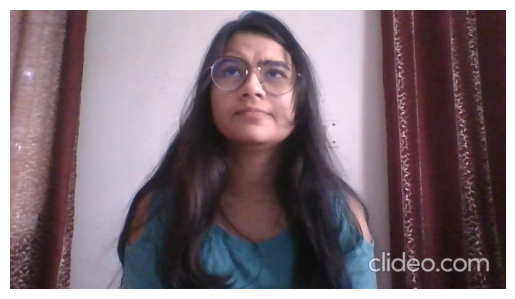

Shape of the image (19745,)


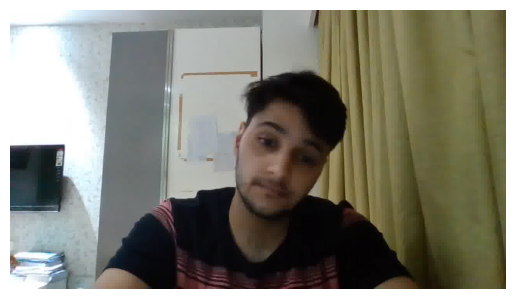

Shape of the image (21216,)


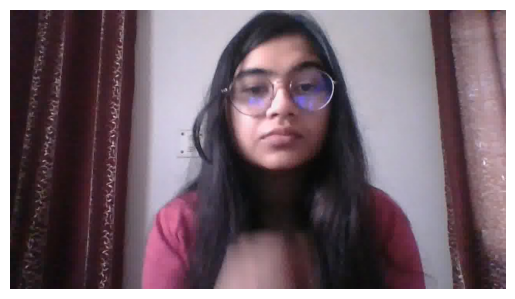

Shape of the image (21813,)


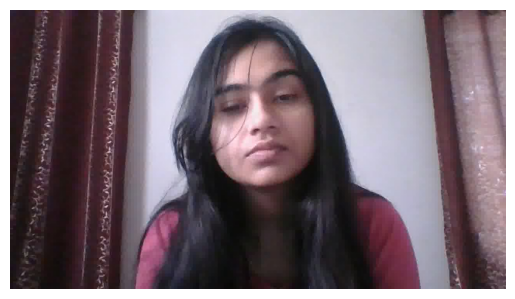

Shape of the image (17353,)


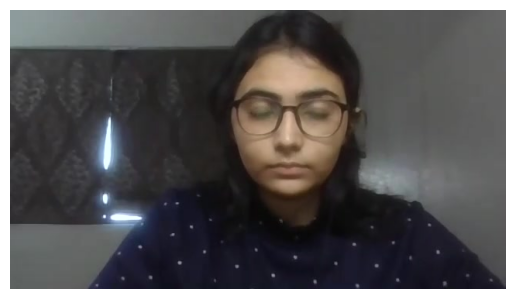

Shape of the image (44759,)


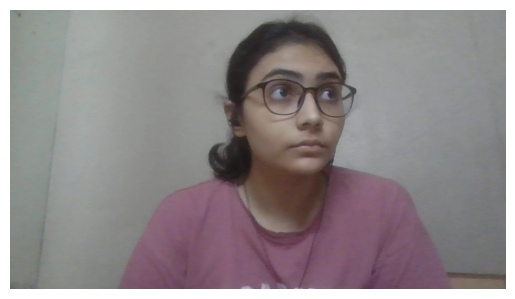

In [39]:
%pylab inline
#learner confused
url_confused = r'https://github.com/ayarii/learner-engagement/blob/main/0020.jpg?raw=true'
resp = requests.get(url_confused, stream=True).raw
image_array_confused = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_confused.shape}')
image_confused = cv2.imdecode(image_array_confused, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_confused, cv2.COLOR_BGR2RGB))
plt.show()

#learner frustrated
url_frustrated = r'https://github.com/ayarii/learner-engagement/blob/main/135.jpg?raw=true'
resp = requests.get(url_frustrated, stream=True).raw
image_array_frustrated= np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_frustrated.shape}')
image_frustrated = cv2.imdecode(image_array_frustrated, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_frustrated, cv2.COLOR_BGR2RGB))
plt.show()

#learner engaged
url_engaged = r'https://github.com/ayarii/learner-engagement/blob/main/0076.jpg?raw=true'
resp = requests.get(url_engaged, stream=True).raw
image_array_engagement = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_engagement.shape}')
image_engagement = cv2.imdecode(image_array_engagement, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
plt.show()

#learner bored
url_bored = r'https://github.com/ayarii/learner-engagement/blob/main/0153.jpg?raw=true'
resp = requests.get(url_bored, stream=True).raw
image_array_bored = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_bored.shape}')
image_bored = cv2.imdecode(image_array_bored, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_bored, cv2.COLOR_BGR2RGB))
plt.show()

#learner drowsy
url_drowsy = r'https://github.com/ayarii/learner-engagement/blob/main/0021.jpg?raw=true'
resp = requests.get(url_drowsy, stream=True).raw
image_array_drowsy = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_drowsy.shape}')
image_drowsy = cv2.imdecode(image_array_drowsy, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_drowsy, cv2.COLOR_BGR2RGB))
plt.show()

# learner looking_away
url_looking_away = r'https://github.com/ayarii/learner-engagement/blob/main/0011.jpg?raw=true'
resp = requests.get(url_looking_away, stream=True).raw
image_array_looking_away = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_looking_away.shape}')
image_looking_away = cv2.imdecode(image_array_looking_away, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_looking_away, cv2.COLOR_BGR2RGB))
plt.show()

In [40]:
batch_size = 1
img_height = 200
img_width = 200
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 2120 files belonging to 6 classes.
Using 1696 files for training.
Found 2120 files belonging to 6 classes.
Using 424 files for validation.
['Looking Away', 'bored', 'confused', 'drowsy', 'engaged', 'frustrated']


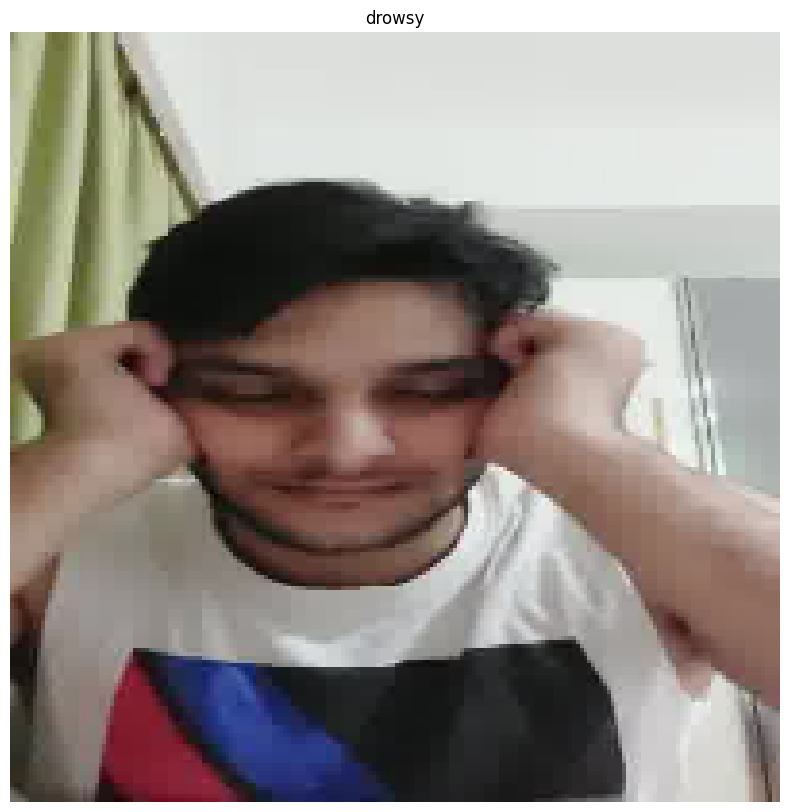

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(1):
    ax = plt.subplot(1, 1, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
num_classes = 6

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Set up callbacks
log_dir = "logs/"
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[tensorboard_callback, early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_data, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 32)       

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1696/1696 [==============================] - 147s 86ms/step - loss: 0.2785 - accuracy: 0.8927 - val_loss: 0.1316 - val_accuracy: 0.9458
Epoch 2/10
1696/1696 [==============================] - 144s 85ms/step - loss: 0.1054 - accuracy: 0.9540 - val_loss: 0.1333 - val_accuracy: 0.9552
Epoch 3/10
1696/1696 [==============================] - 143s 85ms/step - loss: 0.0834 - accuracy: 0.9664 - val_loss: 0.0963 - val_accuracy: 0.9670
Epoch 4/10
1696/1696 [==============================] - 151s 89ms/step - loss: 0.0812 - accuracy: 0.9705 - val_loss: 0.0940 - val_accuracy: 0.9670
Epoch 5/10
1696/1696 [==============================] - 144s 85ms/step - loss: 0.0712 - accuracy: 0.9717 - val_loss: 0.0824 - val_accuracy: 0.9528
Epoch 6/10
1696/1696 [==============================] - 142s 84ms/step - loss: 0.0649 - accuracy: 0.9717 - val_loss: 0.0986 - val_accuracy: 0.9599
Epoch 7/10
1696/1696 [==============================] - 144s 85ms/step - loss: 0.0560 - accuracy: 0.9758 - val_loss: 0.0876 - val

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 32)       

   7/1696 [..............................] - ETA: 32s

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1696/1696 [==============================] - 37s 22ms/step
Epoch 1/10
1696/1696 [==============================] - 142s 84ms/step - loss: 0.0419 - accuracy: 0.9782 - val_loss: 0.1018 - val_accuracy: 0.9575
Epoch 2/10
1696/1696 [==============================] - 140s 83ms/step - loss: 0.0755 - accuracy: 0.9752 - val_loss: 0.1068 - val_accuracy: 0.9575
Epoch 3/10
1696/1696 [==============================] - 137s 81ms/step - loss: 0.0867 - accuracy: 0.9776 - val_loss: 0.0827 - val_accuracy: 0.9528
Epoch 4/10
1696/1696 [==============================] - 142s 84ms/step - loss: 0.0421 - accuracy: 0.9794 - val_loss: 0.1079 - val_accuracy: 0.9646
Epoch 5/10
1696/1696 [==============================] - 140s 83ms/step - loss: 0.0434 - accuracy: 0.9770 - val_loss: 0.1243 - val_accuracy: 0.9575
Epoch 6/10
1696/1696 [==============================] - 139s 82ms/step - loss: 0.0408 - accuracy: 0.9788 - val_loss: 0.1129 - val_accuracy: 0.9623
Epoch 7/10
1696/1696 [==============================] - 140

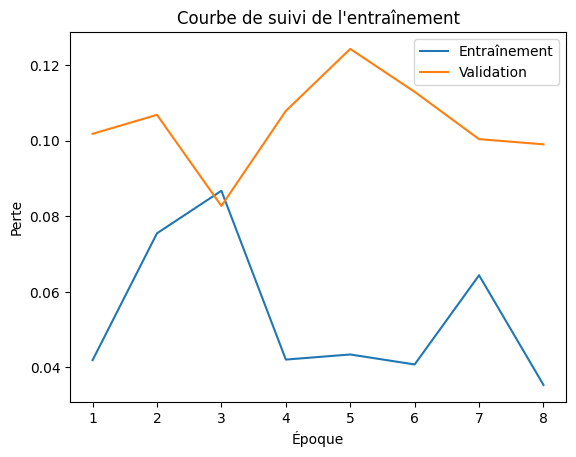

In [49]:
 # Convertir les étiquettes en une représentation binaire
from sklearn.preprocessing import label_binarize
binarized_labels = label_binarize(labels, classes=['Looking Away', 'bored', 'confused', 'drowsy', 'engaged', 'frustrated'])
n_classes = binarized_labels.shape[1]

# Assuming 'train_data' is appropriately prepared and has the same number of samples as 'labels'
scores = model.predict(train_data)

# Assuming 'history' object contains the training and validation loss
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

# Extract the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Entraînement')
plt.plot(epochs, validation_loss, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbe de suivi de l\'entraînement')
plt.legend()
plt.show()

Saving 0011.jpg to 0011.jpg


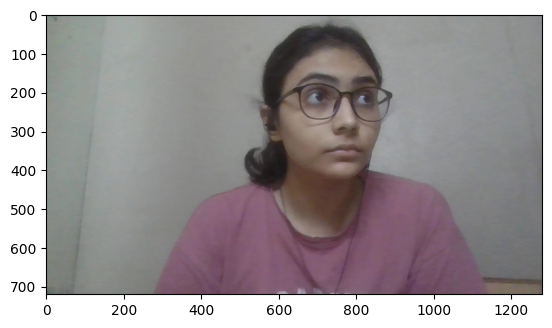

1/1 [==============================] - 0s 114ms/step


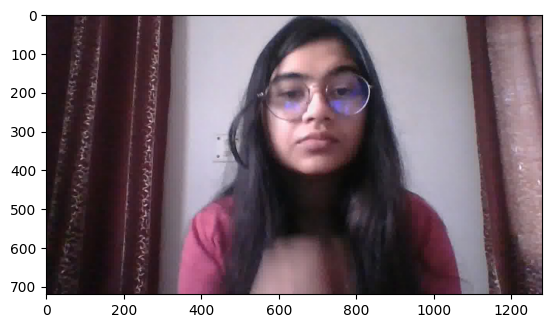

Learner Engaged!


In [52]:
# Cette ligne importe la bibliothèque "files" de Google Colab, qui permet de charger des fichiers depuis votre ordinateur vers l'environnement Colab.
from google.colab import files
# Cette ligne demande à l'utilisateur de télécharger un fichier (une image dans ce cas) vers l'environnement Colab. Le fichier téléchargé sera stocké dans la variable file_to_predict.
file_to_predict = files.upload()
# Cette ligne itère sur les fichiers téléchargés (dans le cas où plusieurs fichiers auraient été téléchargés) et effectue les étapes suivantes pour chaque fichier.
for file_ in file_to_predict:
  #Cette ligne utilise la fonction cv2.imread de la bibliothèque OpenCV pour lire l'image téléchargée à partir du fichier.
  #L'image est stockée dans la variable image_to_predict.
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    #Cette ligne affiche l'image en utilisant plt.imshow de la bibliothèque matplotlib.
    #cv2.cvtColor est utilisé pour convertir l'image du format BGR (utilisé par OpenCV) en format RGB (utilisé par matplotlib).
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    #Cette ligne redimensionne l'image à une taille de 200x200 pixels à l'aide de cv2.resize et l'expands en ajoutant une dimension supplémentaire à l'aide de np.expand_dims.
    #Cela est nécessaire pour que l'image corresponde à la forme attendue par le modèle (une seule image avec les dimensions spécifiées).
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0)
    #Cette ligne effectue la prédiction en utilisant le modèle CNN entraîné (model.predict). La variable res contient les résultats de la prédiction.
    res = model.predict(img_to_predict)
predicted_class = np.argmax(res)  # Obtient l'indice de la classe prédite avec la plus haute probabilité
if predicted_class == 0:
    plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Engaged!")
elif predicted_class == 1:
    plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Not engaged!")
#Ce code permet de charger une image, de faire des prédictions avec le modèle CNN et d'afficher une image correspondant